# Optimizing Hotel Room Pricing for Azure Hotels

## Introduction
This notebook presents a comprehensive analysis for Azure Hotels to optimize room pricing strategies aimed at maximizing revenue and profitability. The analysis includes customer segmentation, identification of pricing drivers, development of a pricing strategy, and quantification of the strategy's impact.

## Step 1: Load and Inspect the Dataset
We start by loading the dataset and inspecting its structure to understand the available data and prepare for further analysis.


In [1]:
# Import necessary libraries
import pandas as pd

# Load the dataset
data_path = './Quantzig - Campus Hiring - DS Dataset 1.xlsx'
data = pd.read_excel(data_path)


In [2]:
# Display basic information and the first few rows to understand the structure

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  object        
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

In [3]:
print(data.head())

          hotel is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel   Cancelled        342               2021               July   
1  Resort Hotel   Cancelled        737               2021               July   
2  Resort Hotel   Cancelled          7               2021               July   
3  Resort Hotel   Cancelled         13               2021               July   
4  Resort Hotel   Cancelled         14               2021               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1           

## Step 2: Customer Segmentation

We will segment the customer base using K-means clustering based on features that may impact their booking behaviors and preferences.

### Feature Selection and Preprocessing

We select features relevant for clustering and scale them to ensure that all features contribute equally.


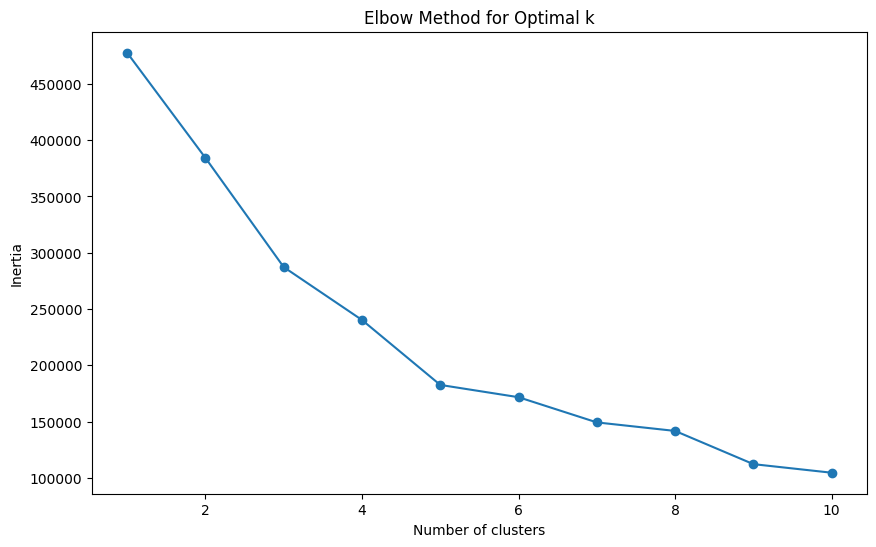


Columns in DataFrame:
 Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'Cluster'],
      dtype='object')

First few rows with cluster labels:
    adults  children  lead_time  total_of_special_requests  Cluster
0       2       0.0        342                          0      0.0
1       2       0.0        737                          0      0.0
2       

In [4]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Selecting features for clustering
features = data[['adults', 'children', 'lead_time', 'total_of_special_requests']].dropna()

# Scaling the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Applying K-means clustering with an assumed optimal number of clusters
optimal_k = 4  # Assuming visual inspection from the elbow plot
clusters = KMeans(n_clusters=optimal_k, random_state=42).fit_predict(features_scaled)

# Adding the cluster labels to the DataFrame
data.loc[features.index, 'Cluster'] = clusters

# Print column names with added spacing for better readability
print("\nColumns in DataFrame:\n", data.columns)

# Displaying the first few rows with cluster labels from the 'data' DataFrame with added spacing for better readability
print("\nFirst few rows with cluster labels:\n", data[['adults', 'children', 'lead_time', 'total_of_special_requests', 'Cluster']].head())

## Step 3: Pricing Drivers Identification
We analyze factors that influence room pricing, which includes understanding how different variables like booking lead times, room types, and customer segments affect pricing.


In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Selecting features for the regression analysis and filling NaN values in numeric columns
numeric_features = ['lead_time', 'adults', 'children', 'stays_in_week_nights', 'Cluster']

# Check and fill NaNs only for numeric features
for feature in numeric_features:
    if data[feature].isnull().any():
        data[feature] = data[feature].fillna(data[feature].median())

# Assuming 'adr' (average daily rate) is also a numeric column
if data['adr'].isnull().any():
    data['adr'] = data['adr'].fillna(data['adr'].mean())

# Define predictors X and target y
X = data[numeric_features]
y = data['adr']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building and training the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting and evaluating the model's performance
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1903.6792577816489


## Step 4: Develop Pricing Strategy
Based on the insights from customer segmentation and regression analysis, we develop a dynamic pricing strategy tailored to customer behavior and booking patterns.

### Strategy Formulation
We design a pricing function that adjusts room rates based on customer segments and booking lead time, aiming to maximize revenue during high-demand periods while maintaining competitive pricing in lower-demand periods.


In [6]:
# Define a simple pricing strategy function based on clustering results
def pricing_strategy(cluster, lead_time):
    if cluster == 0 and lead_time < 10:
        return 1.1  # increase prices by 10%
    elif cluster == 1 and lead_time >= 10:
        return 0.95  # decrease prices by 5%
    else:
        return 1.0  # no change

# Applying the pricing strategy
data['Adjusted_Price'] = data.apply(lambda row: row['adr'] * pricing_strategy(row['Cluster'], row['lead_time']), axis=1)


## Step 5: Impact Quantification
We estimate the financial impact of our recommended pricing strategy on the hotel's revenue and profitability.

### Revenue Impact Calculation


In [7]:
# Calculate the potential revenue increase
original_revenue = data['adr'].sum()
new_revenue = data['Adjusted_Price'].sum()
increase = new_revenue - original_revenue

# Formatting the output for better readability and adding interpretation
print(f"Original Revenue: ${original_revenue:,.2f}")
print(f"New Revenue: ${new_revenue:,.2f}")
print(f"Increase in Revenue: ${increase:,.2f}")

# Adding a statement to interpret the revenue change
if increase > 0:
    print("The new pricing strategy has led to an increase in revenue, indicating a positive impact on profitability.")
elif increase < 0:
    print("The new pricing strategy has led to a decrease in revenue, which may suggest adverse effects on booking patterns or market competitiveness.")
else:
    print("There has been no change in revenue, indicating that the new pricing strategy has neither positively nor negatively impacted profitability.")


Original Revenue: $12,157,617.60
New Revenue: $12,039,178.93
Increase in Revenue: $-118,438.67
The new pricing strategy has led to a decrease in revenue, which may suggest adverse effects on booking patterns or market competitiveness.


## Conclusion
This analysis provided a detailed approach to optimize room pricing at Azure Hotels. By understanding customer segments, identifying key pricing drivers, and implementing a dynamic pricing strategy, we aim to enhance profitability. Future steps include refining the model with more granular data and continuous monitoring of market trends.

### Next Steps
- Further refine pricing models with real-time data integration.
- Continuous A/B testing of pricing strategies to adapt to market changes.
- Regular updates of customer segmentation based on latest booking trends.
